# Reverse Image Product Search


Kevin Kearney

Development Period: T3 - 2025 DiscountMate

----



- Initial proof of concept for reverse image search via camera/image upload. 
- There were no scrapped images available at the start of T3 2025, so I utilised several manually saved ones for a small scale test. 
- I also took several pictures with my phone camera and ran these through the concept test.
- Ideally will look to complete additional development for this in T1 2026. 

In [ ]:
pip install torchvision

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np

# Load pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()

In [8]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        # Everything except the last fc layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Outputs (batch, 512, 1, 1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten to (batch, 512)
        return x

feature_extractor = ResNet18FeatureExtractor(resnet18)

In [9]:
# Preprocessing (same as before)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]    # ImageNet stds
    )
])

def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dim
    with torch.no_grad():
        features = feature_extractor(input_tensor)
    return features.cpu().numpy()[0]

In [ ]:

pip install torch numpy scikit-learn pillow

In [4]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [14]:

def show_image_comparisons(test_img_path, matches):
    """
    Display test image and matched product images side by side.
    'matches' can be a list with one or more matches.
    Here, we pass only the top 1 match to display.
    """
    import matplotlib.pyplot as plt
    num_images = 1 + len(matches)
    plt.figure(figsize=(4 * num_images, 5))
    
    test_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(1, num_images, 1)
    plt.imshow(test_img)
    plt.title("Test Image")
    plt.axis('off')
    
    for i, (prod_name, score, prod_img_path) in enumerate(matches, start=2):
        prod_img = Image.open(prod_img_path).convert('RGB')
        plt.subplot(1, num_images, i)
        plt.imshow(prod_img)
        plt.title(f"{prod_name}\nScore: {score:.4f}")
        plt.axis('off')
    
    plt.show()

Extracting features from product images...
Extracted features for 14 products.

Matching test images to products...

Test image: Test image\awakentest_2.png
  Top 1: awaken_coles (score: 0.7816) - Product image path: product_images\awaken_coles.png
  Top 2: awaken tea (score: 0.7373) - Product image path: product_images\awaken tea.png
  Top 3: t2 wakey (score: 0.7021) - Product image path: product_images\t2 wakey.png



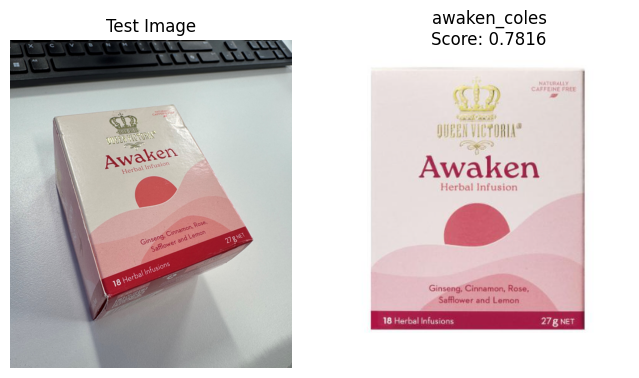

Test image: Test image\awaken_test.jpeg
  Top 1: t2 wakey (score: 0.6822) - Product image path: product_images\t2 wakey.png
  Top 2: awaken_coles (score: 0.6690) - Product image path: product_images\awaken_coles.png
  Top 3: green tea (score: 0.6633) - Product image path: product_images\green tea.png



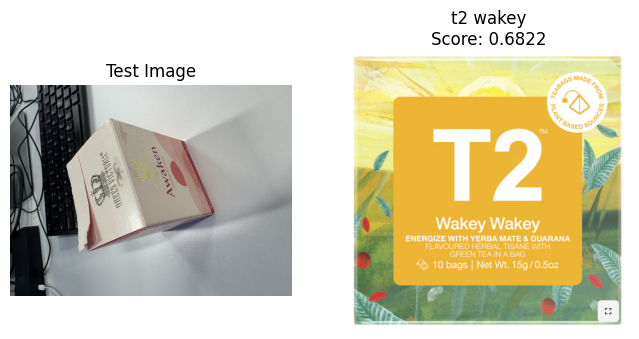

Test image: Test image\cola 1 test.png
  Top 1: cola (score: 0.6940) - Product image path: product_images\cola.png
  Top 2: peanut butter (score: 0.6232) - Product image path: product_images\peanut butter.png
  Top 3: maxibon (score: 0.6128) - Product image path: product_images\maxibon.png



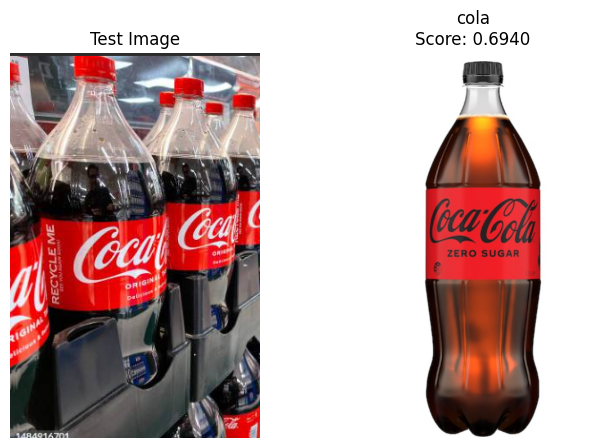

Test image: Test image\focus tea_test.jpeg
  Top 1: focus tea bags (score: 0.7528) - Product image path: product_images\focus tea bags.png
  Top 2: green tea (score: 0.7121) - Product image path: product_images\green tea.png
  Top 3: t2 wakey (score: 0.6898) - Product image path: product_images\t2 wakey.png



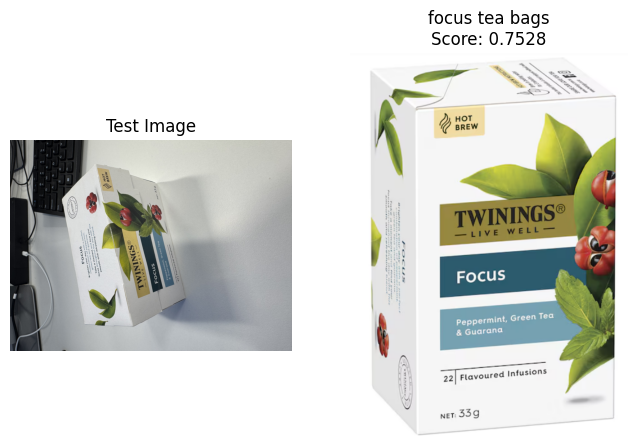

Test image: Test image\tea test 1.png
  Top 1: green tea (score: 0.8251) - Product image path: product_images\green tea.png
  Top 2: tea earl (score: 0.7589) - Product image path: product_images\tea earl.png
  Top 3: focus tea bags (score: 0.7516) - Product image path: product_images\focus tea bags.png



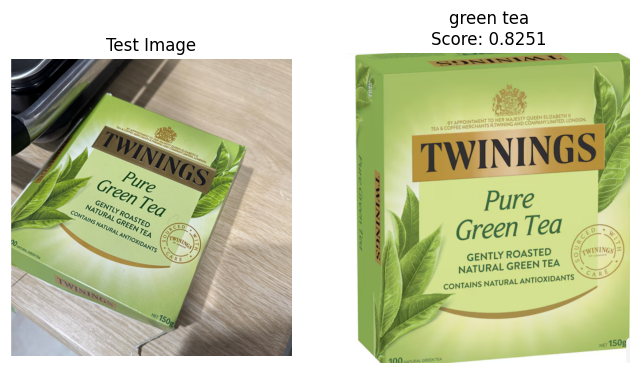

Test image: Test image\wakey_test.jpeg
  Top 1: t2 wakey (score: 0.7526) - Product image path: product_images\t2 wakey.png
  Top 2: grey2 (score: 0.6982) - Product image path: product_images\grey2.png
  Top 3: Cadbury Creations (score: 0.6910) - Product image path: product_images\Cadbury Creations.png



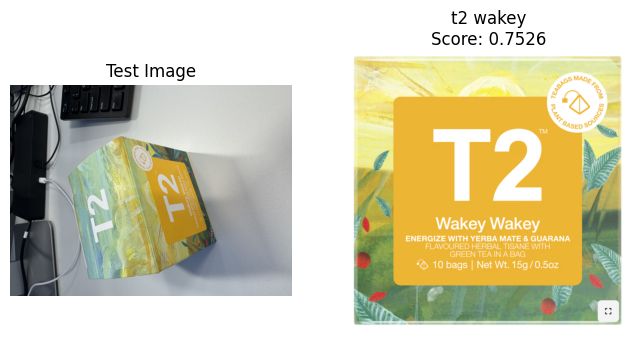

Test image: Test image\zchoc test 3.png
  Top 1: shapes2 (score: 0.7676) - Product image path: product_images\shapes2.png
  Top 2: Cadbury Creations (score: 0.7500) - Product image path: product_images\Cadbury Creations.png
  Top 3: maxibon (score: 0.7327) - Product image path: product_images\maxibon.png



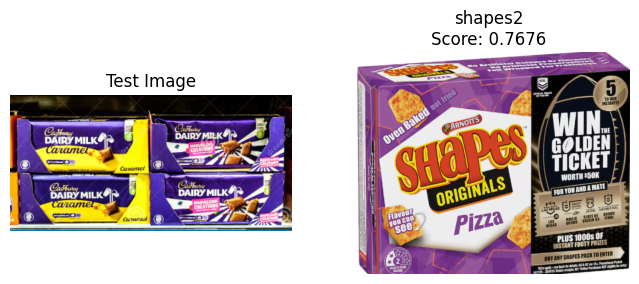

Test image: Test image\zchocbar test 1.png
  Top 1: shapes2 (score: 0.6099) - Product image path: product_images\shapes2.png
  Top 2: Cadbury Creations (score: 0.5989) - Product image path: product_images\Cadbury Creations.png
  Top 3: white choc (score: 0.5732) - Product image path: product_images\white choc.png



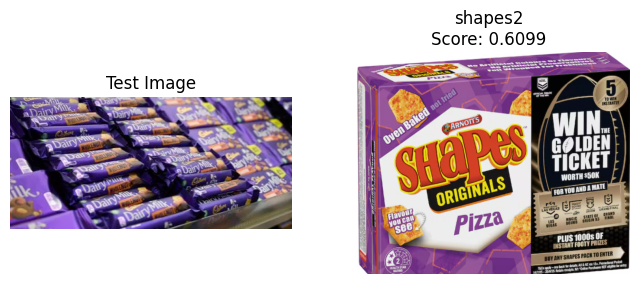

In [20]:
# ----------- Load product images and extract features -----------
product_dir = 'product_images'
product_features = {}
product_paths = {}

print("Extracting features from product images...")
for fname in os.listdir(product_dir):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        product_name = os.path.splitext(fname)[0]
        img_path = os.path.join(product_dir, fname)
        feat = extract_features(img_path)
        product_features[product_name] = feat
        product_paths[product_name] = img_path
print(f"Extracted features for {len(product_features)} products.\n")

# ----------- Matching function -----------
def find_top_k_matches(query_image_path, product_features, product_paths, top_k=3):
    query_vec = extract_features(query_image_path).reshape(1, -1)
    all_features = np.array(list(product_features.values()))
    similarities = cosine_similarity(query_vec, all_features)[0]
    
    # Get top K indices sorted by similarity descending
    top_k_idx = similarities.argsort()[-top_k:][::-1]
    
    results = []
    product_names = list(product_features.keys())
    for idx in top_k_idx:
        product_name = product_names[idx]
        sim_score = similarities[idx]
        prod_img_path = product_paths[product_name]
        results.append((product_name, sim_score, prod_img_path))
    return results

# ----------- Process test images and display results -----------
test_dir = 'Test image'
print("Matching test images to products...\n")

for test_fname in os.listdir(test_dir):
    if test_fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        test_img_path = os.path.join(test_dir, test_fname)
        print(f"Test image: {test_img_path}")
        top_matches = find_top_k_matches(test_img_path, product_features, product_paths, top_k=3)
        for rank, (prod_name, score, prod_path) in enumerate(top_matches, 1):
            print(f"  Top {rank}: {prod_name} (score: {score:.4f}) - Product image path: {prod_path}")
        print()
        show_image_comparisons(test_img_path, top_matches[:1])